In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import *
from kan import KAN
from kan.MLP import MLP
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from IPython.display import display, Math
from sympy import latex

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# --- 1. Dataset Preparation Helper ---
def get_iris_dataset():
    """
    Loads Iris dataset and formats it into the dictionary structure
    required by KAN/MLP.
    """
    print("Loading IRIS dataset...")
    iris = load_iris()
    X = iris.data
    y = iris.target

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dataset = {}
    dtype = torch.get_default_dtype()

    dataset['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
    # Labels must be Long for CrossEntropy
    dataset['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

    return dataset

# --- 2. Train MLP Function ---
def train_mlp(dataset, width, steps=20, seed=42):
    """
    Trains an MLP model.
    Args:
        dataset (dict): The dataset dictionary.
        width (list): Network architecture, e.g., [4, 64, 3].
        steps (int): Training steps (LBFGS).
    Returns:
        model: The trained MLP model.
        results: The history of loss and metrics.
    """
    print(f"Training MLP (Width: {width})...")
    model = MLP(width=width, seed=seed, device=device)
    dtype = torch.get_default_dtype()

    # Define metrics locally so they bind to *this* model instance
    def train_acc():
        pred = torch.argmax(model(dataset['train_input']), dim=1)
        return torch.mean((pred == dataset['train_label']).type(dtype))

    def test_acc():
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        return torch.mean((pred == dataset['test_label']).type(dtype))

    results = model.fit(
        dataset,
        opt="LBFGS",
        steps=steps,
        metrics=(train_acc, test_acc),
        loss_fn=torch.nn.CrossEntropyLoss()
    )

    print(f"MLP Final Test Acc: {results['test_acc'][-1]:.4f}")
    return model, results

# --- 3. Train KAN Function ---
def train_kan(dataset, width, grid=5, k=3, steps=20, seed=42, cont_training=False):
    """
    Trains a KAN model.
    Args:
        width (list): Network architecture, e.g., [4, 3, 3].
        grid (int): Grid size for splines.
        k (int): Spline order.
    """
    print(f"Training KAN (Width: {width}, Grid: {grid}, k: {k})...")
    if cont_training:
        model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, sp_trainable=False, sb_trainable=False, base_fun='zero', noise_scale=0.1)
    else:
        model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=0.1)

    dtype = torch.get_default_dtype()

    # Define metrics locally
    def train_acc():
        pred = torch.argmax(model(dataset['train_input']), dim=1)
        return torch.mean((pred == dataset['train_label']).type(dtype))

    def test_acc():
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        return torch.mean((pred == dataset['test_label']).type(dtype))

    results = model.fit(
        dataset,
        opt="LBFGS",
        steps=steps,
        metrics=(train_acc, test_acc),
        loss_fn=torch.nn.CrossEntropyLoss()
    )



    print(f"KAN Final Test Acc: {results['test_acc'][-1]:.4f}")
    return model, results

# --- 4. Plot Comparison Function ---
def plot_comparison(mlp_res, kan_res):
    """
    Plots training history comparing one MLP and one KAN.
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot 1: Loss ---
    axs[0].plot(kan_res['train_loss'], label='KAN Train Loss', color='blue')
    axs[0].plot(kan_res['test_loss'], label='KAN Test Loss', linestyle='--', color='blue', alpha=0.7)
    axs[0].plot(mlp_res['train_loss'], label='MLP Train Loss', color='orange')
    axs[0].plot(mlp_res['test_loss'], label='MLP Test Loss', linestyle='--', color='orange', alpha=0.7)
    axs[0].set_title("Cross Entropy Loss")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True, linestyle=':', alpha=0.6)

    # --- Plot 2: Accuracy ---
    axs[1].plot(kan_res['train_acc'], label='KAN Train Acc', color='blue')
    axs[1].plot(kan_res['test_acc'], label='KAN Test Acc', linestyle='--', color='blue', alpha=0.7)
    axs[1].plot(mlp_res['train_acc'], label='MLP Train Acc', color='orange')
    axs[1].plot(mlp_res['test_acc'], label='MLP Test Acc', linestyle='--', color='orange', alpha=0.7)
    axs[1].set_title("Classification Accuracy")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True, linestyle=':', alpha=0.6)
    axs[1].set_ylim(0.6, 1.05)

    plt.tight_layout()
    plt.show()


def plot_KAN_graph(kan_model):
    kan_model.plot(scale=1.0, beta=3)
    n = 4
    names = ["Sepal Length (cm)", "Sepal Width (cm)", "Petal Length (cm)", "Petal Width (cm)"]
    for i in range(n):
        plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")


def display_formula(kan_model):
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    kan_model.auto_symbolic(lib=lib)
    formula_iris = kan_model.symbolic_formula()[0]
    print(f"Class 0 Formula (approx):")
    rounded_expr = formula_iris[0].replace(
        lambda d: isinstance(d, Float),
        lambda d: Float(round(d, 4))
    )
    display(Math(latex(rounded_expr)))


Loading IRIS dataset...
Training MLP (Width: [4, 3, 3])...


| train_loss: 2.16e-01 | test_loss: 1.23e-01 | reg: 5.26e+01 | : 100%|█| 60/60 [00:00<00:00, 124.74i


MLP Final Test Acc: 1.0000
Training KAN (Width: [4, 3], Grid: 1, k: 1)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.16e-01 | test_loss: 1.24e-01 | reg: 8.13e+01 | : 100%|█| 200/200 [00:01<00:00, 158.4


saving model version 0.1
KAN Final Test Acc: 1.0000


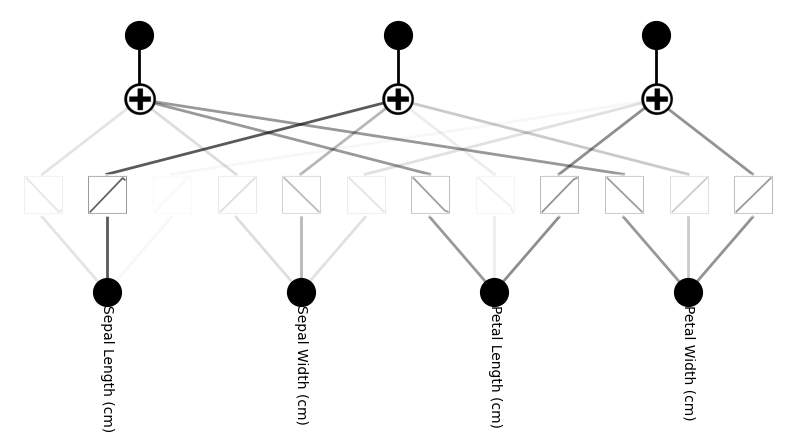

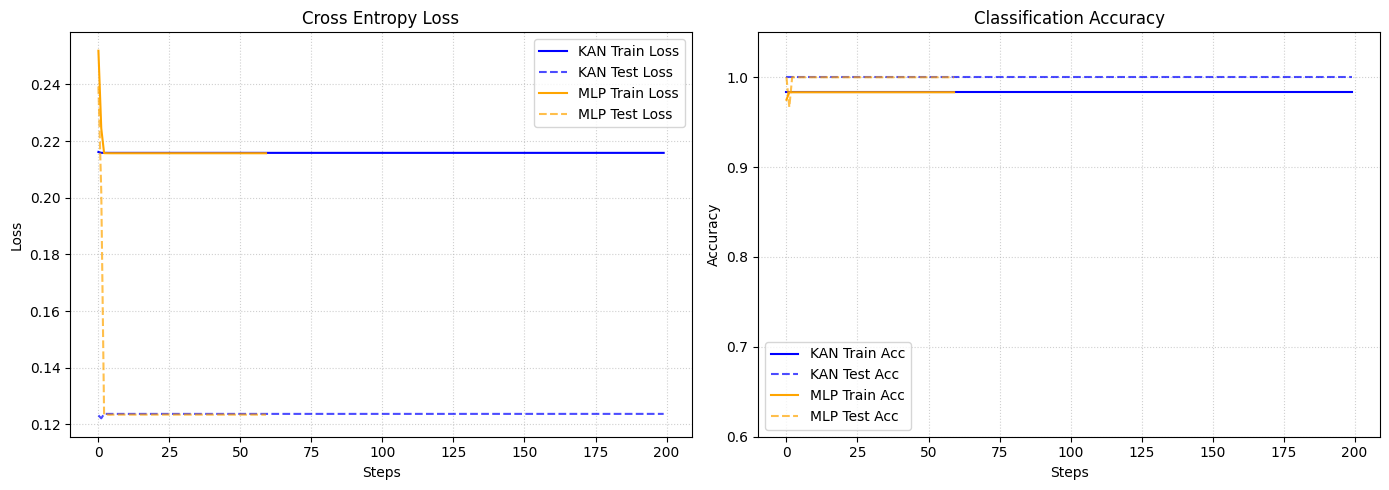

In [26]:
# ==========================================
#               MAIN EXECUTION
# ==========================================

dataset_iris = get_iris_dataset()

# Equivalant parameters:
# MLP = 0 hidden nodes: 15 params: 3 hidden nodes: 27 params
mlp_model, mlp_results = train_mlp(dataset=dataset_iris, width=[4, 3, 3], steps=60)
kan_model_1, kan_results_1 = train_kan(dataset=dataset_iris, width=[4, 3], grid=1, k=1, steps=200, cont_training=True)
#kan_model_2, kan_results_2 = train_kan(dataset=dataset_iris, width=[4, 1, 3], grid=1, k=1, steps=200, cont_training=True)
#kan_model_3, kan_results_3 = train_kan(dataset=dataset_iris, width=[4, 1, 3], grid=1, k=1, steps=200, cont_training=True)

#plot_KAN_graph(mlp_model)

plot_KAN_graph(kan_model_1)
plot_comparison(mlp_results, kan_results_1)
#plot_KAN_graph(kan_model_2)
#plot_comparison(mlp_results, kan_results_2)
#plot_KAN_graph(kan_model_3)
#plot_comparison(mlp_results, kan_results_3)


In [27]:
#display_formula(kan_model_1)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_classification_results(kan_model, mlp_model, dataset):
    # 1. Get Data and Move to CPU
    X_test = dataset['test_input'].detach().cpu().numpy()
    y_test = dataset['test_label'].detach().cpu().numpy()

    # 2. Get Predictions
    # KAN
    kan_logits = kan_model(dataset['test_input'])
    kan_preds = torch.argmax(kan_logits, dim=1).detach().cpu().numpy()

    # MLP
    mlp_logits = mlp_model(dataset['test_input'])
    mlp_preds = torch.argmax(mlp_logits, dim=1).detach().cpu().numpy()

    # 3. Determine Correctness (Boolean masks)
    kan_correct = (kan_preds == y_test)
    mlp_correct = (mlp_preds == y_test)

    # 4. Setup Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Helper to map booleans to colors
    # Green (#2ca02c) for True, Red (#d62728) for False
    def get_colors(mask):
        return np.where(mask, '#2ca02c', '#d62728')

    # --- Plot KAN Results ---
    # Plotting Feature 0 (Sepal Length) vs Feature 1 (Sepal Width)
    axes[0].scatter(
        X_test[:, 0], X_test[:, 1],
        c=get_colors(kan_correct),
        s=70, alpha=0.8, edgecolors='k'
    )
    axes[0].set_title(f'KAN Classification Results\nAccuracy: {np.mean(kan_correct):.2%}')
    axes[0].set_xlabel('Sepal Length')
    axes[0].set_ylabel('Sepal Width')

    # Add legend manually for KAN
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Correct'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728', markersize=10, label='Incorrect')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')

    # --- Plot MLP Results ---
    axes[1].scatter(
        X_test[:, 0], X_test[:, 1],
        c=get_colors(mlp_correct),
        s=70, alpha=0.8, edgecolors='k'
    )
    axes[1].set_title(f'MLP Classification Results\nAccuracy: {np.mean(mlp_correct):.2%}')
    axes[1].set_xlabel('Sepal Length')
    axes[1].set_ylabel('Sepal Width')
    axes[1].legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

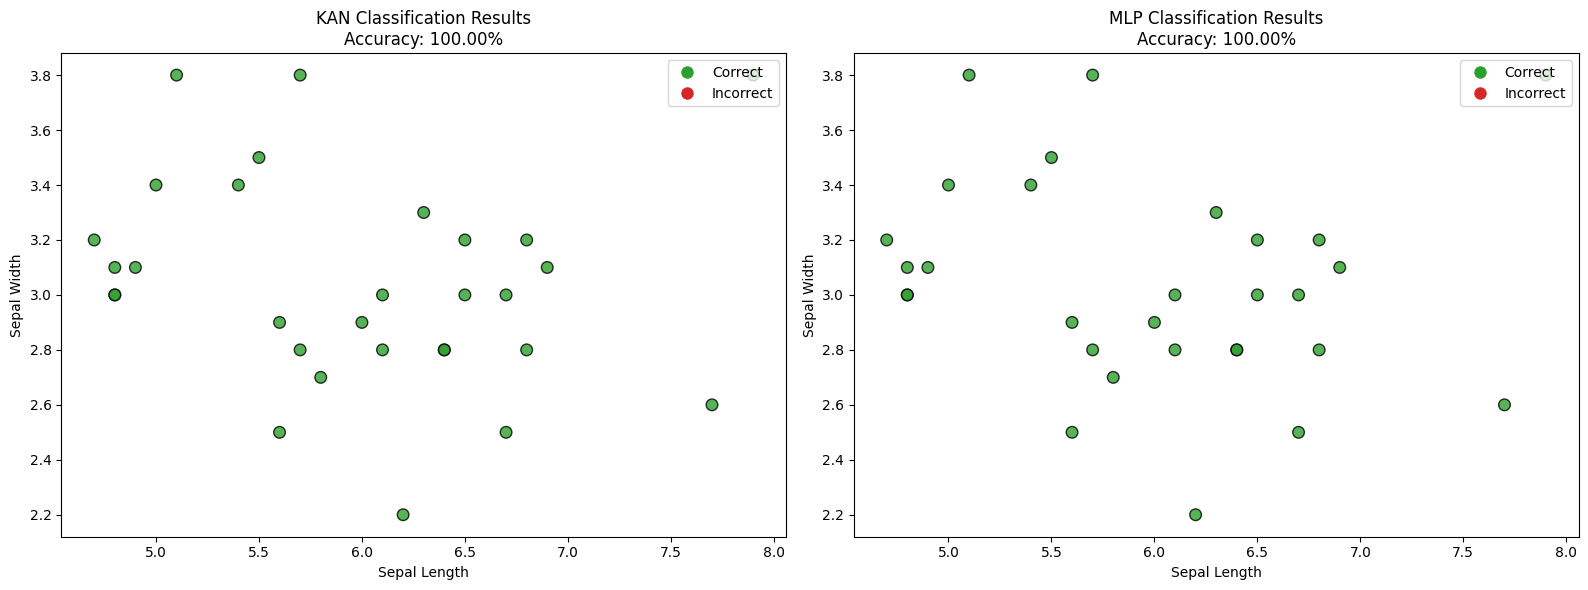

In [29]:
plot_classification_results(kan_model_1, mlp_model, dataset_iris)